<a href="https://colab.research.google.com/github/sudoyolo/israelwar/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff


# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# important libraries
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
df = pd.read_csv('en_data_final.csv')

In [18]:
df.shape

(4000, 13)

In [19]:
df.columns

Index(['Unnamed: 0', 'fullname', 'id', 'likes', 'quotes', 'replies',
       'retweets', 'searchQuery', 'text', 'timestamp', 'username', 'verified',
       'tweets_en'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4000 non-null   int64 
 1   fullname     4000 non-null   object
 2   id           4000 non-null   int64 
 3   likes        4000 non-null   int64 
 4   quotes       4000 non-null   int64 
 5   replies      4000 non-null   int64 
 6   retweets     4000 non-null   int64 
 7   searchQuery  4000 non-null   object
 8   text         3994 non-null   object
 9   timestamp    4000 non-null   object
 10  username     4000 non-null   object
 11  verified     4000 non-null   bool  
 12  tweets_en    3995 non-null   object
dtypes: bool(1), int64(6), object(6)
memory usage: 379.0+ KB


In [21]:
df.isna().sum().sort_values(ascending=False)

text           6
tweets_en      5
Unnamed: 0     0
fullname       0
id             0
likes          0
quotes         0
replies        0
retweets       0
searchQuery    0
timestamp      0
username       0
verified       0
dtype: int64

In [22]:
df[df['text'].isna()]

,Unnamed: 0,fullname,id,likes,quotes,replies,retweets,searchQuery,text,timestamp,username,verified,tweets_en
1576,1576,144p bangtan,1720304163114864868,4120,35,0,1550,Palestine,NaN,2023-11-03T04:57:00.000Z,@144pbangtan,False,in
2334,2334,KABIR,1720318555638698045,0,0,0,0,Gaza,NaN,2023-11-03T05:54:00.000Z,@Humane4gaza,False,in
2478,2478,Fujho 𐤀,1720120326745735450,185,0,0,51,Palestine,NaN,2023-11-02T16:46:00.000Z,@Jk_0128,False,in
3079,3079,alee⁷,1720306412503650355,1796,43,10,736,Palestine,NaN,2023-11-03T05:06:00.000Z,@mimilostjams,False,in
3402,3402,tee⁷ 🎧,1720277912153153679,304,0,1,20,Palestine,NaN,2023-11-03T03:13:00.000Z,@koospersona,False,in
3766,3766,日本近親相姦研究所 (近研）,1720318409953718345,1,0,0,0,Israel,NaN,2023-11-03T05:54:00.000Z,@jabenyss4ku,False,in


In [23]:
df[df['tweets_en'].isna()]

,Unnamed: 0,fullname,id,likes,quotes,replies,retweets,searchQuery,text,timestamp,username,verified,tweets_en
1027,1027,🅰️C | Free Palestine 🇵🇸,1720318647472705654,0,0,0,0,Palestine,😭😭,2023-11-03T05:55:00.000Z,@AC2802M,False,NaN
2068,2068,•,1720138420218146943,23874,205,66,18273,Palestine,❤️🇵🇸,2023-11-02T17:58:00.000Z,@Al__Quraan,True,NaN
3340,3340,TonTon Jo Palestine 🙏🤲❤️😪,1720318241078145274,0,0,0,0,Palestine,❤️❤️❤️🙏🙏🙏🤲🤲🤲😪😪😪,2023-11-03T05:53:00.000Z,@jsette60,False,NaN
3345,3345,OSMANLI,1720318490429608139,0,0,0,0,Israel,🔥🔥🔥,2023-11-03T05:54:00.000Z,@ayyuzlum44,False,NaN
3497,3497,pengintip050700,1720318463795941482,0,0,0,0,Israel,🍉🍉🍉🍉,2023-11-03T05:54:00.000Z,@EmiEmiatmasari1,False,NaN


In [31]:
df = df.drop(df[df['text'] == 'NaN'].index)
df = df.drop([1027, 2068, 3340, 3345, 3497])
df.isna().sum().sort_values(ascending=False)

Unnamed: 0     0
fullname       0
id             0
likes          0
quotes         0
replies        0
retweets       0
searchQuery    0
text           0
timestamp      0
username       0
verified       0
tweets_en      0
dtype: int64

In [32]:
sentiment_df = df[['id', 'tweets_en', 'searchQuery']] # Filtering Columns

In [33]:
sentiment_df.head

<bound method NDFrame.head of                        id                                          tweets_en  \
0     1720266274700403081  French Defense Minister Sebastien Lecornu said...   
1     1719276638695792776  He tweeted this mocking kids in Gaza, and now ...   
2     1720042989756486027  “Innocent Palestinian civilians” in Gaza celeb...   
3     1719822081439711680  Let's Not Be Blind to Palestinian Suffering 🕊️...   
4     1720024940445856083  Gaza: Attacks on hospitals & schools have take...   
...                   ...                                                ...   
3995  1719156913378558382  For those who don't know, watermelon is used a...   
3996  1720318302180851807  And ?\n\nYou hate Israel & Jews what do you ex...   
3997  1720318302025667046  Blinken to visit Israel, push for ‘humanitaria...   
3998  1720318298263335180  I wish our sunni countries r not coward then w...   
3999  1720318290700972244  What an iconic Juana giving looks to the thous...   

     sear

In [11]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# ROBERTA

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
import urllib
import csv
labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [34]:
from scipy.special import softmax
from tqdm import tqdm  # import tqdm

BATCH_SIZE = 10
MAX_LEN = 128  # set maximum sequence length
scores_all = np.empty((0, len(labels)))
text_all = sentiment_df['tweets_en'].to_list()
n = len(text_all)

with torch.no_grad():
    for start_idx in tqdm(range(0, n, BATCH_SIZE)):  # add tqdm here
        end_idx = min(start_idx+BATCH_SIZE, n)
        batch_text = text_all[start_idx:end_idx]
        encoded_input = tokenizer.batch_encode_plus(batch_text,
                                                     max_length=MAX_LEN,
                                                     padding='max_length',
                                                     truncation=True,
                                                     return_tensors='pt').to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()

sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)


100%|██████████| 399/399 [25:21<00:00,  3.81s/it]


In [36]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", index=False)

# BOW SENTIMENT ANALYSIS DATASET BUILD

In [37]:
from textblob import TextBlob
def get_sentiment(tweet):
    sentiment = TextBlob(tweet).sentiment
    return sentiment.polarity, sentiment.subjectivity

sentiment_df['sentiment'] = sentiment_df['tweets_en'].apply(get_sentiment)

In [38]:
sentiment_df['polarity'] = sentiment_df['sentiment'].apply(lambda x:x[0])
sentiment_df['subjectivity'] = sentiment_df['sentiment'].apply(lambda x:x[0])

In [39]:
sentiment_df.drop('sentiment', axis=1, inplace=True)

In [40]:
sentiment_df.to_csv("./Tweets_Sentiment_Analysis_BOW_Raw_Values.csv", index=False)

# EMOTIONAL ANALYSIS

In [41]:
emotion_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [42]:
task='emotion'
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# READING THE SENTIMENT CSV DATA FROM ROBERTA

In [43]:
tweet_df = pd.read_csv("./Tweets_Sentiment_Analysis_RoBERTa_Raw_Values.csv", lineterminator='\n')

In [46]:
tweet_df.insert(6, "Sentiment", '')

In [47]:
for i in range(len(tweet_df)):
  if tweet_df['negative'][i] > tweet_df['positive'][i] and tweet_df['negative'][i] > tweet_df['neutral'][i]:
    tweet_df['Sentiment'][i] = 'negative'
  elif tweet_df['positive'][i] > tweet_df['negative'][i] and tweet_df['positive'][i] > tweet_df['neutral'][i]:
    tweet_df['Sentiment'][i]= 'positive'
  else:
    tweet_df['Sentiment'][i] = 'neutral'

In [49]:
tweet_df.drop(['negative','positive','neutral'], axis=1, inplace=True)

In [51]:
tweet_df.to_csv("./Tweets_Sentiment_Analysis_RoBERTa.csv", index=False)

<Axes: xlabel='Sentiment', ylabel='count'>

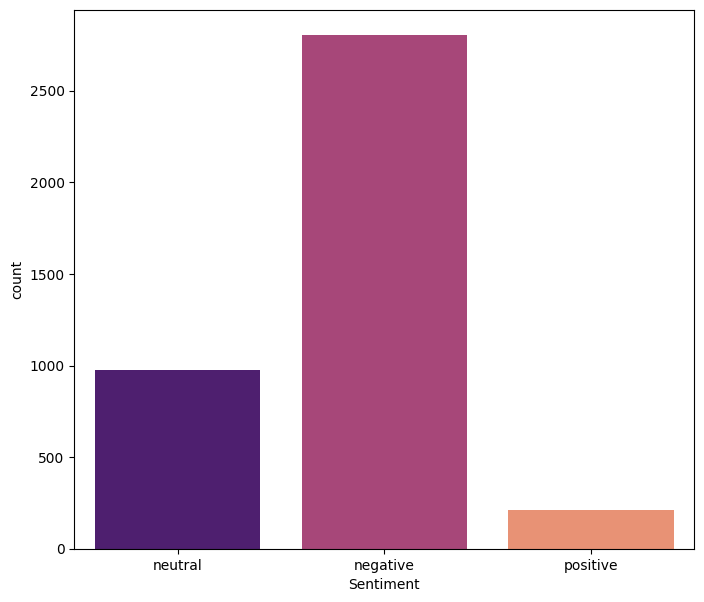

In [52]:
plt.figure(figsize = (8,7))
sns.countplot(x="Sentiment", data=tweet_df, palette='magma')

# Pre-Processing the Sentiment Dataframe

In [54]:
dataset = tweet_df[['Sentiment','tweets_en']]
text, sentiment = list(dataset['tweets_en']), list(dataset['Sentiment'])

In [55]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [56]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"#remove link
    userPattern       = '@[^\s]+'#remove tags
    alphaPattern      = "[^a-zA-Z0-9]"#remove alphanumeric charecters
    sequencePattern   = r"(.)\1\1+"#remove dots
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()#lowercase tweet

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [64]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [65]:
import time
import nltk
import os

nltk.data.path.append(os.path.abspath('<path-to-nltk-data-directory>'))

nltk.download('wordnet')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text Preprocessing complete.
Time Taken: 2 seconds


In [66]:
processedtext = preprocess(text)
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [69]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  77650


In [70]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# EVALUATION

BERNOULLI

In [71]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
ys_predict = BNBmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.71      0.99      0.83       141
     neutral       0.00      0.00      0.00        48
    positive       0.00      0.00      0.00        11

    accuracy                           0.70       200
   macro avg       0.24      0.33      0.28       200
weighted avg       0.50      0.70      0.58       200

Confusion Matrix: 
 [[140   1   0]
 [ 48   0   0]
 [ 10   1   0]]
Accuracy Score: 
 0.7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K NEAREST NEIGHBOURS

In [72]:
KNNModel = KNeighborsClassifier(n_neighbors=5)
KNNModel.fit(X_train, y_train)
ys_predict = KNNModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.72      0.94      0.82       141
     neutral       0.29      0.08      0.13        48
    positive       1.00      0.09      0.17        11

    accuracy                           0.69       200
   macro avg       0.67      0.37      0.37       200
weighted avg       0.63      0.69      0.62       200

Confusion Matrix: 
 [[133   8   0]
 [ 44   4   0]
 [  8   2   1]]
Accuracy Score: 
 0.69


DECISION TREE CLASSIFIER

In [73]:
DTCModel = DecisionTreeClassifier(random_state=0)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.70      0.70      0.70       141
     neutral       0.25      0.27      0.26        48
    positive       0.00      0.00      0.00        11

    accuracy                           0.56       200
   macro avg       0.32      0.32      0.32       200
weighted avg       0.55      0.56      0.56       200

Confusion Matrix: 
 [[99 37  5]
 [34 13  1]
 [ 9  2  0]]
Accuracy Score: 
 0.56


RANDOM FOREST

In [74]:
RFCModel = RandomForestClassifier(n_estimators=100)
RFCModel.fit(X_train, y_train)
ys_predict = RFCModel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.72      0.99      0.83       141
     neutral       0.67      0.08      0.15        48
    positive       0.00      0.00      0.00        11

    accuracy                           0.71       200
   macro avg       0.46      0.36      0.33       200
weighted avg       0.67      0.71      0.62       200

Confusion Matrix: 
 [[139   2   0]
 [ 44   4   0]
 [ 11   0   0]]
Accuracy Score: 
 0.715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LOGISTIC REGRESSION

In [75]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
ys_predict = LRmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.71      0.99      0.83       141
     neutral       0.50      0.02      0.04        48
    positive       0.00      0.00      0.00        11

    accuracy                           0.70       200
   macro avg       0.40      0.34      0.29       200
weighted avg       0.62      0.70      0.59       200

Confusion Matrix: 
 [[140   1   0]
 [ 47   1   0]
 [ 11   0   0]]
Accuracy Score: 
 0.705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [76]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
ys_predict = SVCmodel.predict(X_test)
#Display the outcome of classification
print('Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))

Classification Report: 
               precision    recall  f1-score   support

    negative       0.72      0.96      0.82       141
     neutral       0.40      0.08      0.14        48
    positive       0.00      0.00      0.00        11

    accuracy                           0.70       200
   macro avg       0.37      0.35      0.32       200
weighted avg       0.60      0.70      0.61       200

Confusion Matrix: 
 [[136   5   0]
 [ 44   4   0]
 [ 10   1   0]]
Accuracy Score: 
 0.7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
